In [1]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import shap
import lime
import os
# from joblib import dump
import joblib
import warnings
import statsmodels.api as sm
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K
from keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import wandb
warnings.filterwarnings('ignore')
# import dask.dataframe as dd


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
exps_dir = "../../../exps"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/exp"
os.makedirs(save_dir, exist_ok=True)

In [3]:
style_dir='../../../styles'
plt.style.use(f'{style_dir}/style.mplstyle')
shap.initjs()

In [4]:
wandb.init(project="enefit_prediction_consumer")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [5]:
ndays=1
X=pd.read_csv(f'{save_dir}/X_train_lag{ndays}_pre_processing.csv', index_col=None)
y=pd.read_csv(f'{save_dir}/y_train_lag{ndays}_pre_processing.csv', index_col=None)
X_train=pd.read_csv(f'{save_dir}/X_train_train_lag{ndays}_pre_processing.csv', index_col=None)
X_valid=pd.read_csv(f'{save_dir}/X_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
y_train=pd.read_csv(f'{save_dir}/y_train_train_lag{ndays}_pre_processing.csv', index_col=None)
y_valid=pd.read_csv(f'{save_dir}/y_valid_train_lag{ndays}_pre_processing.csv', index_col=None)
scaler_y=joblib.load(f'{save_dir}/scaler_y.pkl')
best_params = dict(np.load(f'{save_dir}/best_params_.npz',allow_pickle=True))
target_valid=pd.read_csv(f'{save_dir}/target_valid{ndays}_pre_processing.csv', index_col=None)
target_valid.drop(columns=['Unnamed: 0'], inplace=True)


In [6]:
X.drop(columns=['Unnamed: 0'], inplace=True)
y.drop(columns=['Unnamed: 0'], inplace=True)
X_train.drop(columns=['Unnamed: 0'], inplace=True)
X_valid.drop(columns=['Unnamed: 0'], inplace=True)
y_train.drop(columns=['Unnamed: 0'], inplace=True)
y_valid.drop(columns=['Unnamed: 0'], inplace=True)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1086844, 102) (1086844, 1) (535312, 102) (535312, 1)


In [7]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

lr = 0.0001

model = Sequential()

features = len(X_train.columns)

# First LSTM layer
model.add(LSTM(units=50, input_shape=((features,1))))  # Adjust input_shape if needed
model.add(Dropout(0.2))


# Dense layer with ReLU activation
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.2))

# Output layer with linear activation for regression
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr), loss='mae', metrics=['mae',r2])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 13001 (50.79 KB)
Trainable params: 13001 (50.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
early_stopping = EarlyStopping(monitor='val_loss',
                                mode='min',
    min_delta=0.00005,
    patience=15,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=6,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.hdf5',  # Đường dẫn để lưu model
    monitor='val_loss',  # Theo dõi val_loss
    mode='min',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1,  # Hiển thị thông báo khi lưu model
    save_format="tf"
)

In [10]:
model.fit(X_train,y_train,
          validation_data=(X_valid,y_valid),
          batch_size=64,epochs= 10000, callbacks=[wandb.keras.WandbCallback(metric_aliases={'mae': 'mean_absolute_error','r2':'r2','val_mae':'val_mean_absolute_error', 'val_r2':'val_r2'}),early_stopping,lr_scheduler,checkpoint_callback])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1394 - mae: 0.1394 - r2: 0.6685INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best)... Done. 0.0s



Epoch 1: val_loss improved from inf to 0.12682, saving model to best_model.hdf5
16982/16982 [==============================] - 444s 26ms/step - loss: 0.1394 - mae: 0.1394 - r2: 0.6685 - val_loss: 0.1268 - val_mae: 0.1268 - val_r2: 0.7981 - lr: 1.0000e-04
Epoch 2/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1088 - mae: 0.1088 - r2: 0.7557INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best\assets


INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best)... Done. 0.0s



Epoch 2: val_loss improved from 0.12682 to 0.09702, saving model to best_model.hdf5
16982/16982 [==============================] - 445s 26ms/step - loss: 0.1088 - mae: 0.1088 - r2: 0.7557 - val_loss: 0.0970 - val_mae: 0.0970 - val_r2: 0.8809 - lr: 1.0000e-04
Epoch 3/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1046 - mae: 0.1046 - r2: 0.7641
Epoch 3: val_loss did not improve from 0.09702
16982/16982 [==============================] - 458s 27ms/step - loss: 0.1046 - mae: 0.1046 - r2: 0.7641 - val_loss: 0.1075 - val_mae: 0.1075 - val_r2: 0.8477 - lr: 1.0000e-04
Epoch 4/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.1026 - mae: 0.1026 - r2: 0.7530
Epoch 4: val_loss did not improve from 0.09702
16982/16982 [==============================] - 463s 27ms/step - loss: 0.1026 - mae: 0.1026 - r2: 0.7530 - val_loss: 0.1206 - val_mae: 0.1206 - val_r2: 0.8318 - lr: 1.0000e-04
Epoch 5/10000
16982/16982 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best\assets
wandb: Adding directory to artifact (e:\User\PC\ads_enefit_ueh\ads_enfit\prj\6.deep_learning_models\LSTM\wandb\run-20240715_023213-p9o80qrv\files\model-best)... Done. 0.0s



Epoch 5: val_loss improved from 0.09702 to 0.09496, saving model to best_model.hdf5
16982/16982 [==============================] - 459s 27ms/step - loss: 0.1009 - mae: 0.1009 - r2: 0.7777 - val_loss: 0.0950 - val_mae: 0.0950 - val_r2: 0.8835 - lr: 1.0000e-04
Epoch 6/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0993 - mae: 0.0993 - r2: 0.7816
Epoch 6: val_loss did not improve from 0.09496
16982/16982 [==============================] - 489s 29ms/step - loss: 0.0993 - mae: 0.0993 - r2: 0.7816 - val_loss: 0.1041 - val_mae: 0.1041 - val_r2: 0.8772 - lr: 1.0000e-04
Epoch 7/10000
16981/16982 [============================>.] - ETA: 0s - loss: 0.0977 - mae: 0.0977 - r2: 0.7737
Epoch 7: val_loss did not improve from 0.09496
16982/16982 [==============================] - 468s 28ms/step - loss: 0.0977 - mae: 0.0977 - r2: 0.7737 - val_loss: 0.0974 - val_mae: 0.0974 - val_r2: 0.8754 - lr: 1.0000e-04
Epoch 8/10000
16980/16982 [============================>.] - ETA: 0s - los

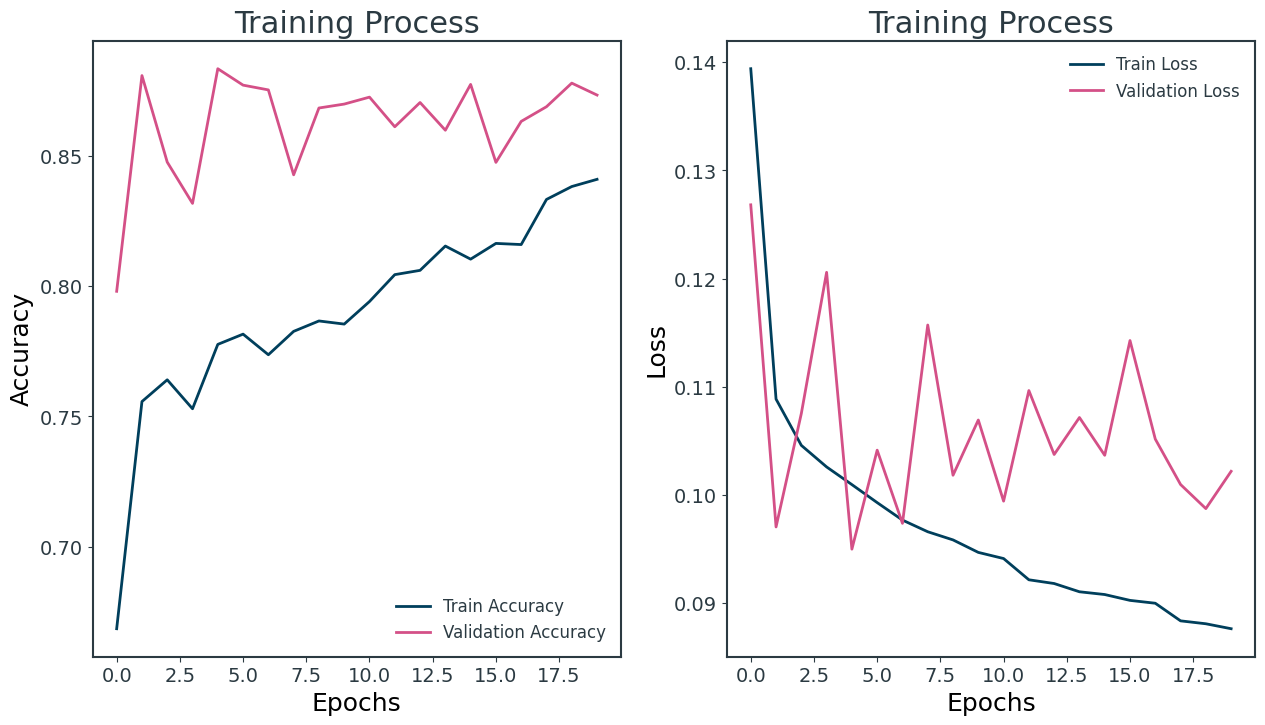

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

history = model.history.history

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].plot(pd.DataFrame(history['r2']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_r2']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(pd.DataFrame(history['mae']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_mae']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.show()


In [12]:
model.history.history['r2']

[0.6685110926628113,
 0.7557266354560852,
 0.7640864849090576,
 0.7529661655426025,
 0.7776811122894287,
 0.7816184759140015,
 0.7737042307853699,
 0.7826812267303467,
 0.7866760492324829,
 0.7854755520820618,
 0.7941414713859558,
 0.8044614195823669,
 0.8061053156852722,
 0.8154400587081909,
 0.8104093074798584,
 0.8164495825767517,
 0.8160127401351929,
 0.8333303928375244,
 0.8382850885391235,
 0.841055154800415]

In [13]:
# Truy cập vào lịch sử của mô hình
training_history = model.history.history

# In ra các keys của lịch sử
print(training_history.keys())

# In ra các giá trị của loss và accuracy qua các epochs
print(training_history['loss'])
print(training_history['val_loss'])

dict_keys(['loss', 'mae', 'r2', 'val_loss', 'val_mae', 'val_r2', 'lr'])
[0.1394108533859253, 0.10884702950716019, 0.10456719249486923, 0.10257098823785782, 0.10093524307012558, 0.09927041083574295, 0.09765422344207764, 0.09657450020313263, 0.0958196222782135, 0.09466447681188583, 0.09409581124782562, 0.09213029593229294, 0.09178484976291656, 0.09102160483598709, 0.09076657146215439, 0.09022479504346848, 0.08996056020259857, 0.08833102136850357, 0.08806155622005463, 0.08760307729244232]
[0.12681902945041656, 0.09701917320489883, 0.10751302540302277, 0.12057537585496902, 0.09496358036994934, 0.10412158817052841, 0.0973535105586052, 0.11570029705762863, 0.10180274397134781, 0.10691305249929428, 0.09940642863512039, 0.109636589884758, 0.10372224450111389, 0.10714313387870789, 0.10364747792482376, 0.11426421254873276, 0.10514789819717407, 0.10094565898180008, 0.09871511906385422, 0.10216651856899261]


In [14]:
from sklearn.metrics import r2_score, mean_absolute_error

# Dự đoán trên tập validation
y_pred = model.predict(X_valid)

# Tính toán R2 Score
r2 = r2_score(y_valid, y_pred)

# Tính toán MAE
mae = mean_absolute_error(y_valid, y_pred)

print(f"R2 Score: {r2}")
print(f"MAE: {mae}")


16729/16729 [==============================] - 102s 6ms/step
R2 Score: 0.8877621117678788
MAE: 0.09496370550365399
